In [1]:
# !wget https://drive.google.com/drive/u/1/my-drive/SRAF_dataset.zip


In [2]:
# ! unzip SRAF_dataset.zip

In [3]:
## or to download from my Google Disk
##! unzip /content/drive/MyDrive/SRAF_dataset.zip


In [4]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import numpy as np
import random
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
from PIL import Image
from sklearn import preprocessing
from pathlib import Path

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

/tmp/ipykernel_29376/2825779402.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485), (0.229))
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize((0.485), (0.229))
    ]),
}
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './SRAF_dataset'
VAL_DIR = Path('./SRAF_dataset/val')
val_files = sorted(list(VAL_DIR.rglob('*.tif') ))

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()


In [6]:
class_names,dataset_sizes

(['no_sraf_on_image', 'sraf_on_image'], {'train': 202, 'val': 191})

In [7]:
print(dataset_sizes)
#dataset_sizes['train']


{'train': 202, 'val': 191}


In [8]:
image_datasets['train'][90]

(tensor([[[-0.7822, -0.3712, -0.6109,  ..., -0.3712, -0.5767, -0.3027],
          [-0.6794, -0.7308, -0.8164,  ..., -0.7308, -0.7479, -0.6965],
          [-0.5596, -0.7650, -0.6794,  ..., -0.8849, -0.6281, -0.6281],
          ...,
          [-0.6109, -0.5424, -0.7650,  ..., -0.8335, -0.2171, -0.0116],
          [-0.5253, -0.5596, -0.1999,  ..., -0.5082, -0.0287, -0.0801],
          [-0.5253, -0.4568, -0.5082,  ..., -0.5253,  0.2282,  0.0912]],
 
         [[-0.7822, -0.3712, -0.6109,  ..., -0.3712, -0.5767, -0.3027],
          [-0.6794, -0.7308, -0.8164,  ..., -0.7308, -0.7479, -0.6965],
          [-0.5596, -0.7650, -0.6794,  ..., -0.8849, -0.6281, -0.6281],
          ...,
          [-0.6109, -0.5424, -0.7650,  ..., -0.8335, -0.2171, -0.0116],
          [-0.5253, -0.5596, -0.1999,  ..., -0.5082, -0.0287, -0.0801],
          [-0.5253, -0.4568, -0.5082,  ..., -0.5253,  0.2282,  0.0912]],
 
         [[-0.7822, -0.3712, -0.6109,  ..., -0.3712, -0.5767, -0.3027],
          [-0.6794, -0.7308,

Label: 1


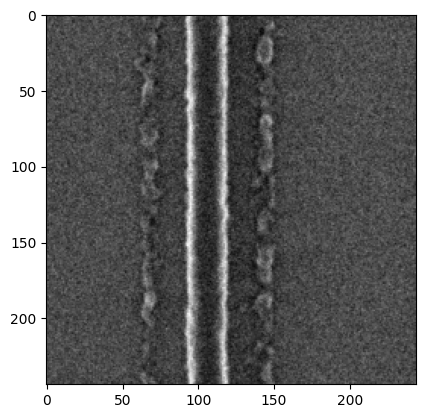

In [9]:
img_1, label_1 = image_datasets['train'][155]
plt.imshow(img_1[2,:,:], cmap='gray')
print('Label:', label_1)
# Label '0' for NO_SRAF image,
# LAbel '1' for SRAF image

In [10]:
#generate a list of 10 random numbers
random_numb = random.sample(range(0, dataset_sizes['train']), 10)
print(random_numb)

[98, 194, 107, 10, 66, 130, 124, 103, 200, 77]


In [11]:
#@title
for i,j in enumerate(random_numb):
  print(i,j)


0 98
1 194
2 107
3 10
4 66
5 130
6 124
7 103
8 200
9 77


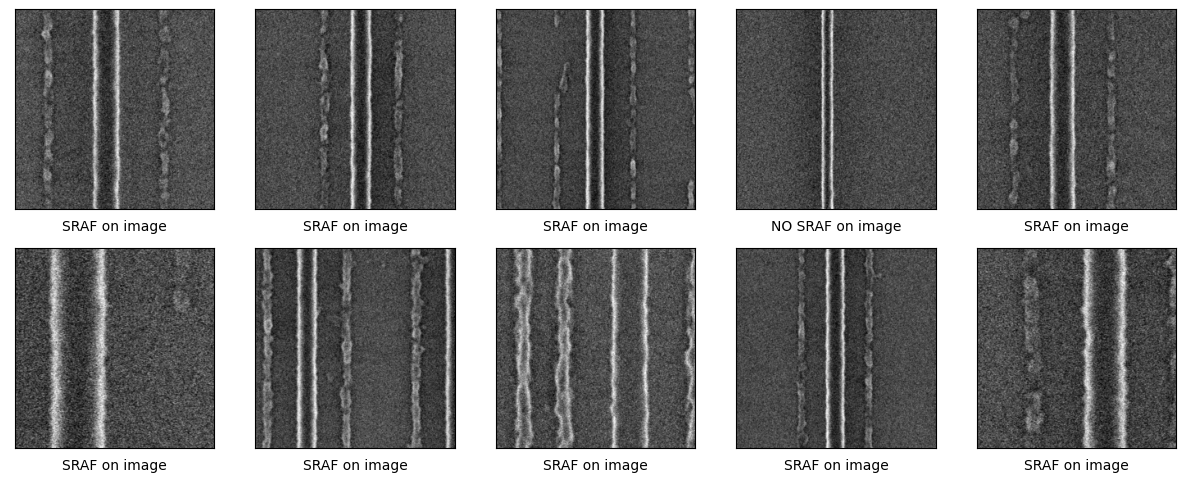

In [12]:
# Show 10 random images from train dataset
#inputs, classes = next(iter(dataloaders['val']))
plt.figure(figsize=(15,15))
for i,j in enumerate(random_numb):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img, label = image_datasets['train'][j]
    plt.imshow(img[2,:,:], cmap='gray')

    if label == 0:
      plt.xlabel("NO SRAF on image")
    elif label == 1:
      plt.xlabel("SRAF on image")
    #plt.xlabel(class_names[train_labels[i][0]])
plt.show()

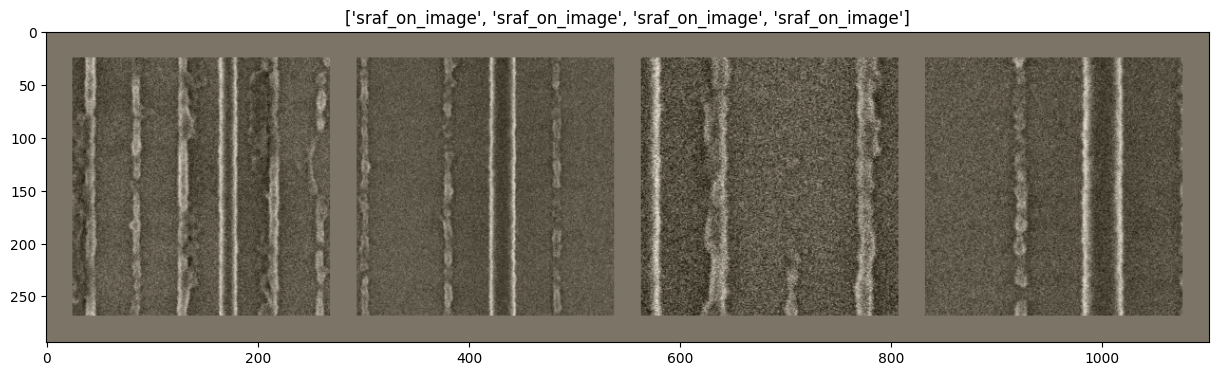

In [13]:
#@title
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs, padding = 25)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
#@title
for i in dataloaders['train']:
    print(i[0][0])
    break


tensor([[[ 0.3994,  0.1426, -0.7137,  ...,  0.8618,  0.7077,  1.1015],
         [-0.3369, -0.1486, -0.1486,  ...,  1.0159,  1.0331,  1.2214],
         [-0.5082, -0.8335, -0.1999,  ...,  0.2282,  1.2385,  1.4954],
         ...,
         [-0.2342, -0.5424, -0.5424,  ...,  0.4851,  0.2453,  0.4166],
         [-0.0116, -0.1486, -0.5082,  ...,  0.5022,  0.0398,  0.1254],
         [-0.5082, -0.1314, -0.3541,  ...,  1.7523,  0.5022,  0.0227]],

        [[ 0.3994,  0.1426, -0.7137,  ...,  0.8618,  0.7077,  1.1015],
         [-0.3369, -0.1486, -0.1486,  ...,  1.0159,  1.0331,  1.2214],
         [-0.5082, -0.8335, -0.1999,  ...,  0.2282,  1.2385,  1.4954],
         ...,
         [-0.2342, -0.5424, -0.5424,  ...,  0.4851,  0.2453,  0.4166],
         [-0.0116, -0.1486, -0.5082,  ...,  0.5022,  0.0398,  0.1254],
         [-0.5082, -0.1314, -0.3541,  ...,  1.7523,  0.5022,  0.0227]],

        [[ 0.3994,  0.1426, -0.7137,  ...,  0.8618,  0.7077,  1.1015],
         [-0.3369, -0.1486, -0.1486,  ...,  1

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    n_epoch=0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}
    accur= {'train': [], 'val': []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            accur[phase].append(epoch_acc)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                n_epoch=epoch

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} on epoch {}'.format(best_acc,n_epoch))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, accur

In [16]:
#@title
def visualizze_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            plt.imshow(inputs.cpu().data[j][2,:,:])

            if images_so_far == num_images:
                return

In [17]:
def predict(model, test_loader):
    model.eval()
    logits=[]
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forward pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        logits.append(list(predicted.numpy()))
    return logits    


In [18]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [19]:
model = models.alexnet(pretrained=True)

/usr/lib64/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib64/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 50)


# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model, losses, accuracies = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib64/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

train iter::   0%|          | 0/51 [00:00<?, ?it/s]

val iter::   0%|          | 0/48 [00:00<?, ?it/s]

Training complete in 0m 57s
Best val Acc: 0.900524 on epoch 5


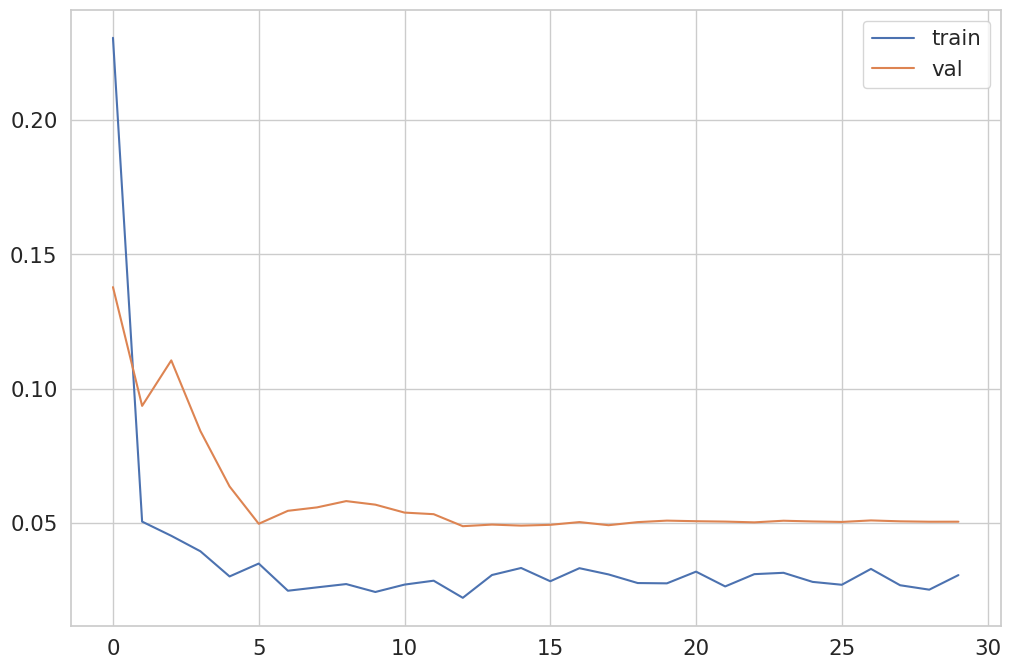

In [23]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

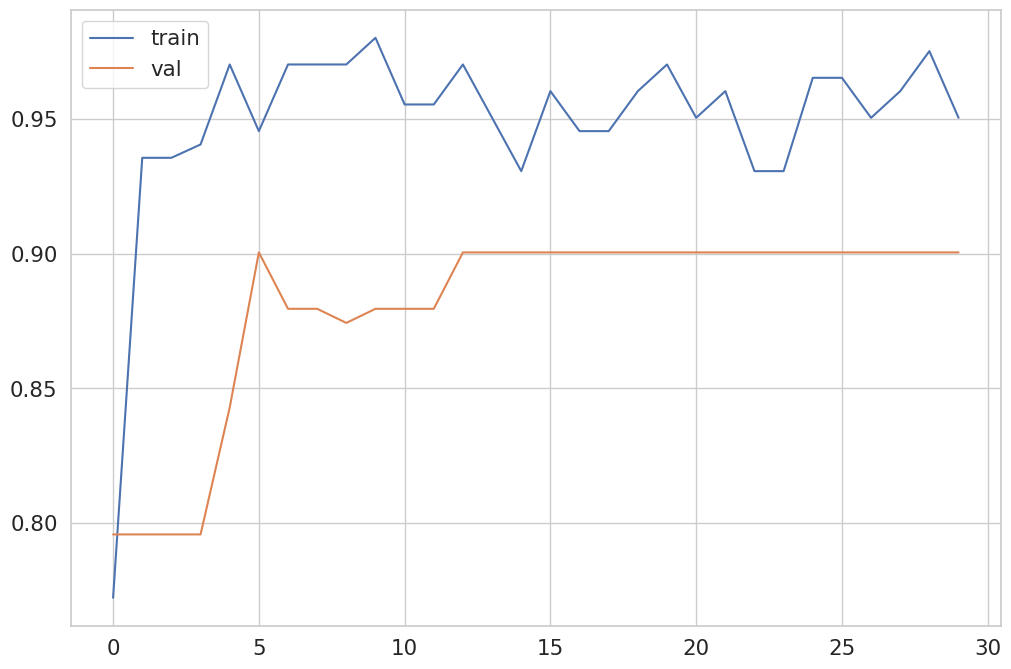

In [24]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график accuracy при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(accuracies['train'], label="train")
plt.plot(accuracies['val'], label="val")
plt.legend()
plt.show()

In [25]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9005


In [26]:
torch.save(model, 'AlexNet_SRAF_1.pth')

In [27]:
new_model = torch.load('AlexNet_SRAF_1.pth')

In [28]:
test ne

SyntaxError: invalid syntax (936429131.py, line 1)

Now let's look how the model works in a prediction mode. 

We iterate through batches in validation dataloader(batch_size =4). We get inputs, labels and outputs of th =e model. After for loop we print the result of last iteration, i.e. 3 final images. we have tensor 
of size ([ [3, 3, 244, 244] ]), zero dimension for batch size = 3 images in a batch. 

Therefore we have 3 labels. Ouptuts size = batch_size x number_of_classess = 3 X 2 = 6

After that we take the prediction of a model by taking the max element in each row of an output. This way we get a prediction. 

In [ ]:
for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = new_model(inputs)
        


In [ ]:
print(inputs.size())
print(labels)
print(outputs)
_, preds = torch.max(outputs.data, 1)
probs = torch.softmax(outputs.data, dim = 1)
print(preds)
print(probs)
print(class_names[preds[2]])
print(inputs.data[0].size())
print(inputs.data[0][2,:,:].size())


In [ ]:
import matplotlib.pyplot as plt

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(14,10))

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        pred_probs = torch.softmax(outputs.data, dim=1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2,3,images_so_far)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(inputs.cpu().data[j][2,:,:], cmap='gray') ## or we can write: plt.imshow(inputs.data[j].permute(1,2,0), cmap='gray')
            plt.xlabel(f"Predicted label:{preds[j]} {labels[j]}\n Probability:{pred_probs[j].max():.2f} ", fontsize=12)

            if images_so_far == num_images:
                return

In [ ]:
visualize_model(new_model)
